In [207]:
import os
if os.path.exists('train/'):
    pass
else:
    %cd ..

In [241]:
import pandas as pd


joint_map = {
            'head': [0, 1, 2], 'neck': [3], 'torso': [4], 'left_front_leg': [5, 6, 7],
            'right_front_leg': [8, 9, 10], 'left_hind_leg': [11, 12, 13], 'right_hind_leg': [14, 15, 16],
        }
label_map = {'grazing': 0, 'standing': 1, 'lying': 2, 'unknown': -1}

df = pd.read_csv('data/action/master.csv')
df['image_path'] = df['image_path'].str.replace('action_data/', '')
df['image_path'] = df['image_path'].apply(lambda x: os.path.join('data/action', x))
df['pose_path'] = df['pose_path'].str.replace('/mnt/nfs/processed/action_data/', 'data/action/')
df.head()

image_path     Label  \
0  data/action/test/2025-03-05_14-00-00~14-10-00_...   grazing   
1  data/action/test/2025-03-05_14-00-00~14-10-00_...  standing   
2  data/action/test/2025-03-05_14-00-00~14-10-00_...   grazing   
3  data/action/test/2025-03-05_14-00-00~14-10-00_...  standing   
4  data/action/test/2025-03-05_14-00-00~14-10-00_...  standing   

                                           pose_path  
0  data/action/poses/2025-03-05_14-00-00~14-10-00...  
1  data/action/poses/2025-03-05_14-00-00~14-10-00...  
2  data/action/poses/2025-03-05_14-00-00~14-10-00...  
3  data/action/poses/2025-03-05_14-00-00~14-10-00...  
4  data/action/poses/2025-03-05_14-00-00~14-10-00...

# Action

In [242]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from omegaconf import DictConfig, OmegaConf
import hydra
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score
from torchvision import transforms as T
import torchvision.models as models
from PIL import Image, ImageDraw, UnidentifiedImageError
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt

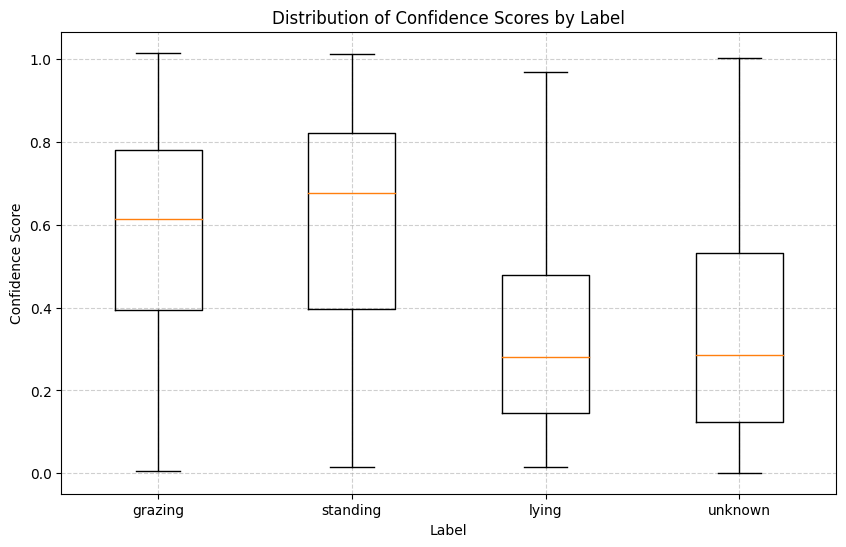

/tmp/ipykernel_2455573/2152169871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # suptitleとの重なりを避ける


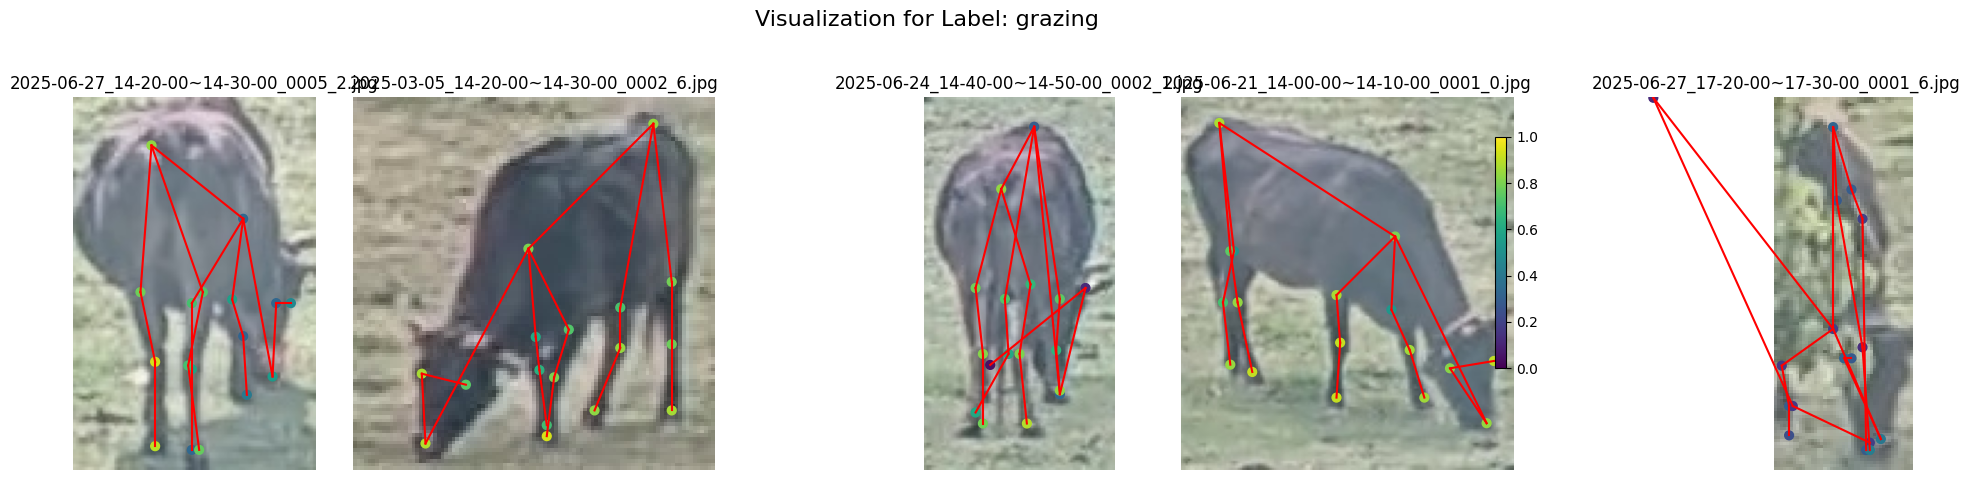

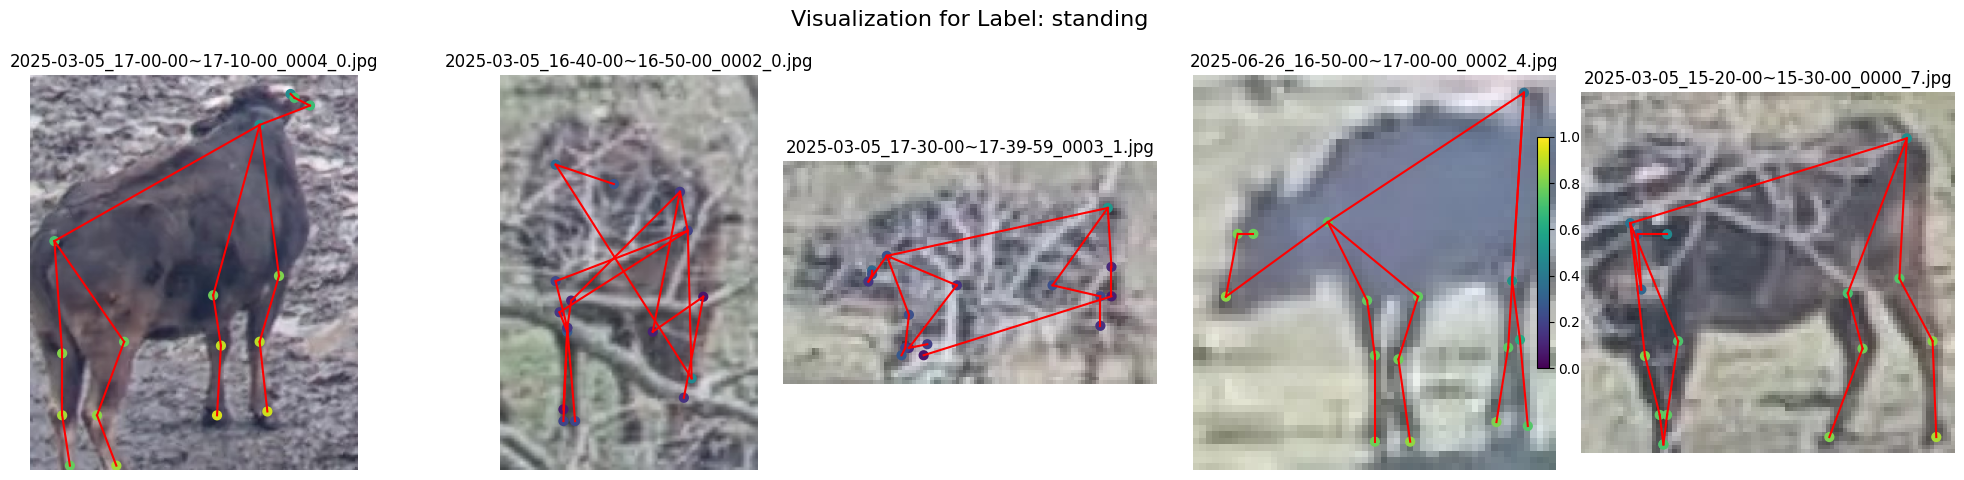

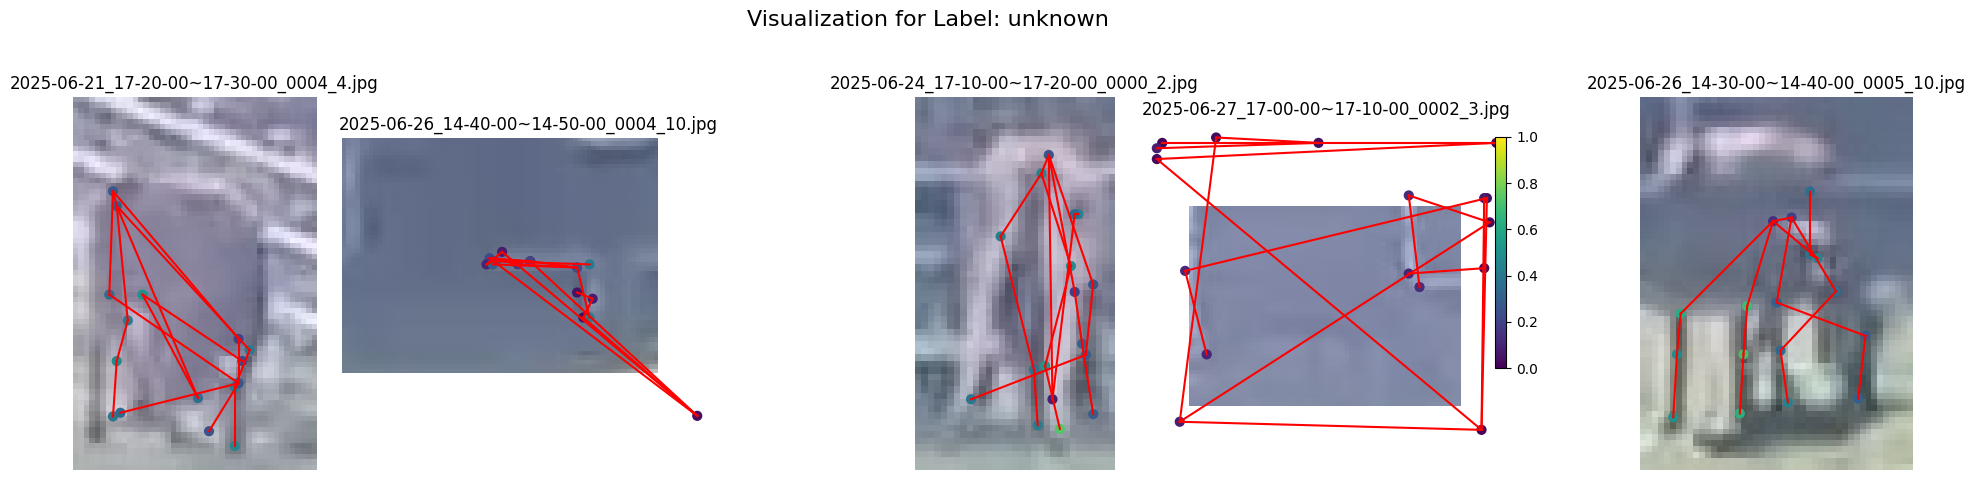

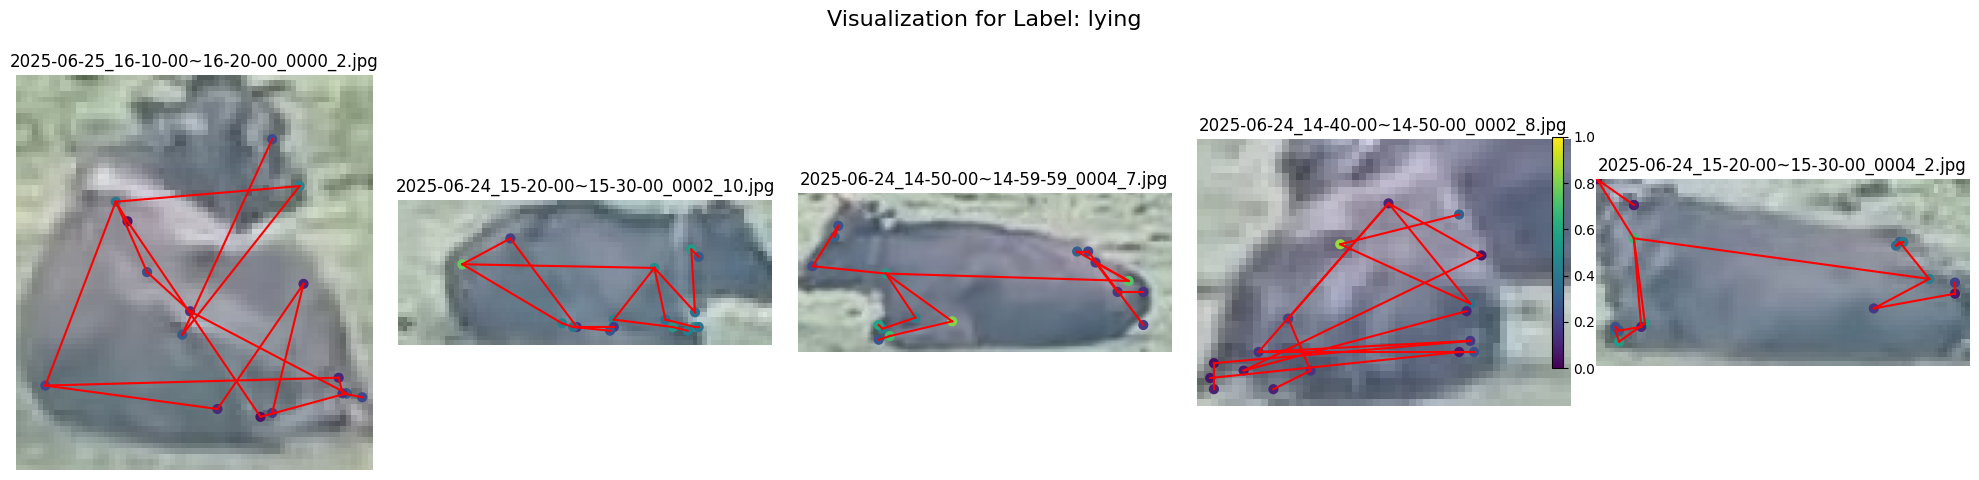

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


# 2. ラベルごとのConfidence分布の可視化
# 全ての骨格データから信頼度を抽出し、ラベルごとに集約する。
labels = label_map.keys()
confidence_by_label = {label: [] for label in labels}
for index, row in df.iterrows():
    pose = np.load(row['pose_path'])
    confidence_by_label[row['Label']].extend(pose[:, 2])

# 箱ひげ図で分布をプロットする。
plt.figure(figsize=(10, 6))
plt.boxplot(confidence_by_label.values(), labels=confidence_by_label.keys())
plt.title('Distribution of Confidence Scores by Label')
plt.ylabel('Confidence Score')
plt.xlabel('Label')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# 3. ラベルごとの5枚の可視化結果の表示
# 各ラベルについて、最初の5サンプルを取得し、骨格情報を画像に描画する。
body_parts_connections = {
    'head': [0, 1, 2], 'torso': [2, 3, 4], 
    'left_front_leg': [3, 5, 6, 7], 'right_front_leg': [3, 8, 9, 10],
    'left_hind_leg': [4, 11, 12, 13], 'right_hind_leg': [4, 14, 15, 16]
}

unique_labels = df['Label'].unique()
for label in unique_labels:
    # 各ラベルについて5つのサンプルを描画領域に並べる。
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle(f'Visualization for Label: {label}', fontsize=16)
    
    # ラベルに該当するデータのうち、先頭5件を取得する。
    label_df = df[df['Label'] == label].sample(5)
    
    for i, (index, row) in enumerate(label_df.iterrows()):
        ax = axes[i]
        image = Image.open(row['image_path']).convert('RGB')
        loaded_skeleton = np.load(row['pose_path'])
        
        ax.imshow(image)
        x, y, confidence = loaded_skeleton.T
        
        # 信頼度に基づきキーポイントを色付けしてプロットする。
        scatter = ax.scatter(x, y, c=confidence, s=40, cmap='viridis', vmin=0, vmax=1)
        
        # キーポイントを線で結ぶ。
        for part, indices in body_parts_connections.items():
            for j in range(len(indices) - 1):
                start_idx, end_idx = indices[j], indices[j+1]
                ax.plot(x[[start_idx, end_idx]], y[[start_idx, end_idx]], 'r-')
        
        ax.set_title(os.path.basename(row['image_path']))
        ax.axis('off')

    # カラーバーをFigureに追加する。
    fig.colorbar(scatter, ax=axes.ravel().tolist(), shrink=0.6)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # suptitleとの重なりを避ける
    plt.show()

In [244]:
import random
import math
import numpy as np
from PIL import Image, ImageDraw

class ImageMaskingFromSkeleton:
    """
    骨格情報に基づき、元の画像にラベル不変のマスキングを適用するTransformである。
    Cutout領域が保護対象のキーポイントと重複する場合、再試行を行う。
    TODO: 判別不可能なマスキング処理を行った場合には[0, 0, 0]とし、Unknownラベルに対応
    """
    def __init__(self, joint_map, cutout_prob=0.5, n_holes=1,
                 scale=(0.02, 0.2), ratio=(0.3, 3.3), max_trials=10):
        """
        Args:
            joint_map (dict): 部位名と骨格点インデックスのマッピングである。
            cutout_prob (float): CutOutを適用する確率である。
            n_holes (int): マスキングする領域の数である。
            scale (tuple): 画像面積に対するマスク面積の比率の範囲である。
            ratio (tuple): マスクのアスペクト比の範囲である。
            max_trials (int): 保護キーポイントを避けるための最大試行回数である。
        """
        self.joint_map = joint_map
        self.cutout_prob = cutout_prob
        self.max_n_holes = n_holes
        self.scale = scale
        self.ratio = ratio
        self.max_trials = max_trials

        # マスキング「可能」部位の定義
        label_to_maskable_parts = {
            0: ['left_hind_leg', 'right_hind_leg'],  # grazing
            1: ['left_hind_leg', 'right_hind_leg'],  # standing
            2: [],  # lying は骨格推定結果が信頼できないため、マスキングしない
        }

        # 上記を反転させ、ラベル毎の「保護対象」部位を定義する
        all_parts = set(self.joint_map.keys())
        self.label_to_protected_parts = {
            label: list(all_parts - set(maskable))
            for label, maskable in label_to_maskable_parts.items()
        }

    def __call__(self, image, skeleton, label):
        """
        入力画像に対し、保護キーポイントを避けながらランダムなCutoutを適用する。
        """
        # if skeleton mean confidence under 0.4, return original image
        if skeleton[:, 2].mean() < 0.4:
            return image

        # determine n_holes with random at 0 to max_n_holes(prob: cutout_prob)
        n_holes = self.max_n_holes

        image_copy = image.copy()
        draw = ImageDraw.Draw(image_copy)
        img_w, img_h = image.size
        img_area = img_w * img_h

        label_item = label.item() if hasattr(label, 'item') else label
        protected_parts = self.label_to_protected_parts.get(label_item)
        if not protected_parts:
            # 保護対象がない場合は通常のCutOutと同様の処理でよいが、
            # ここでは何もしない実装とする
            return image

        # 保護対象のキーポイント座標群を取得
        protected_indices = {idx for part in protected_parts for idx in self.joint_map.get(part, [])}
        skeleton_np = skeleton.cpu().numpy() if hasattr(skeleton, 'cpu') else skeleton
        protected_kpts = skeleton_np[list(protected_indices), :2]
        valid_protected_kpts = protected_kpts[(protected_kpts[:, 0] > 1) & (protected_kpts[:, 1] > 1)]

        for _ in range(n_holes):
            for _ in range(self.max_trials):
                # Cutout領域の面積とアスペクト比をランダムに決定
                hole_area = img_area * random.uniform(self.scale[0], self.scale[1])
                aspect_ratio = random.uniform(self.ratio[0], self.ratio[1])
                
                h = int(round(math.sqrt(hole_area / aspect_ratio)))
                w = int(round(math.sqrt(hole_area * aspect_ratio)))

                if h >= img_h or w >= img_w:
                    continue

                # バッファ項の定義
                buf = 10

                # Cutout領域の左上の座標をランダムに決定
                x1 = random.randint(0, img_w - w)
                y1 = random.randint(0, img_h - h)
                x2, y2 = x1 + w, y1 + h

                # 保護キーポイントとの衝突チェック
                is_colliding = np.any(
                    (valid_protected_kpts[:, 0] >= x1 - buf) &
                    (valid_protected_kpts[:, 0] < x2 + buf) &
                    (valid_protected_kpts[:, 1] >= y1 - buf) &
                    (valid_protected_kpts[:, 1] < y2 + buf)
                )

                if not is_colliding:
                    draw.rectangle([x1, y1, x2, y2], fill='black')
                    break  # 衝突がなければ次のholeの生成へ

        return image_copy

aug_image_masking = ImageMaskingFromSkeleton(
    joint_map=joint_map,
    cutout_prob=1.0, n_holes=5, scale=(0.02, 0.1), ratio=(0.5, 3),
)

In [245]:
import random
import math
import numpy as np
from PIL import Image, ImageDraw
import torch
import matplotlib.pyplot as plt
import os

class StandardCutout:
    """
    画像上のランダムな位置にCutoutを適用するTransform。
    骨格情報による保護は行わない。
    """
    def __init__(self, cutout_prob=0.5, n_holes=1,
                 scale=(0.02, 0.2), ratio=(0.3, 3.3)):
        """
        Args:
            cutout_prob (float): CutOutを適用する確率。
            n_holes (int): マスキングする領域の数。
            scale (tuple): 画像面積に対するマスク面積の比率の範囲。
            ratio (tuple): マスクのアスペクト比の範囲。
        """
        self.cutout_prob = cutout_prob
        self.n_holes = n_holes
        self.scale = scale
        self.ratio = ratio

    def __call__(self, image, skeleton, label):
        """
        入力画像に対し、ランダムなCutoutを適用する。
        """
        if random.random() > self.cutout_prob:
            return image

        image_copy = image.copy()
        draw = ImageDraw.Draw(image_copy)
        img_w, img_h = image.size
        img_area = img_w * img_h

        for _ in range(self.n_holes):
            # Cutout領域の面積とアスペクト比をランダムに決定
            hole_area = img_area * random.uniform(self.scale[0], self.scale[1])
            aspect_ratio = random.uniform(self.ratio[0], self.ratio[1])
            
            h = int(round(math.sqrt(hole_area / aspect_ratio)))
            w = int(round(math.sqrt(hole_area * aspect_ratio)))

            if h >= img_h or w >= img_w:
                continue

            # Cutout領域の左上の座標をランダムに決定
            x1 = random.randint(0, img_w - w)
            y1 = random.randint(0, img_h - h)
            x2, y2 = x1 + w, y1 + h

            draw.rectangle([x1, y1, x2, y2], fill='black')
            
        return image_copy

aug_standard_cutout = StandardCutout(
    cutout_prob=1.0, n_holes=5, scale=(0.02, 0.1), ratio=(0.5, 3),
)

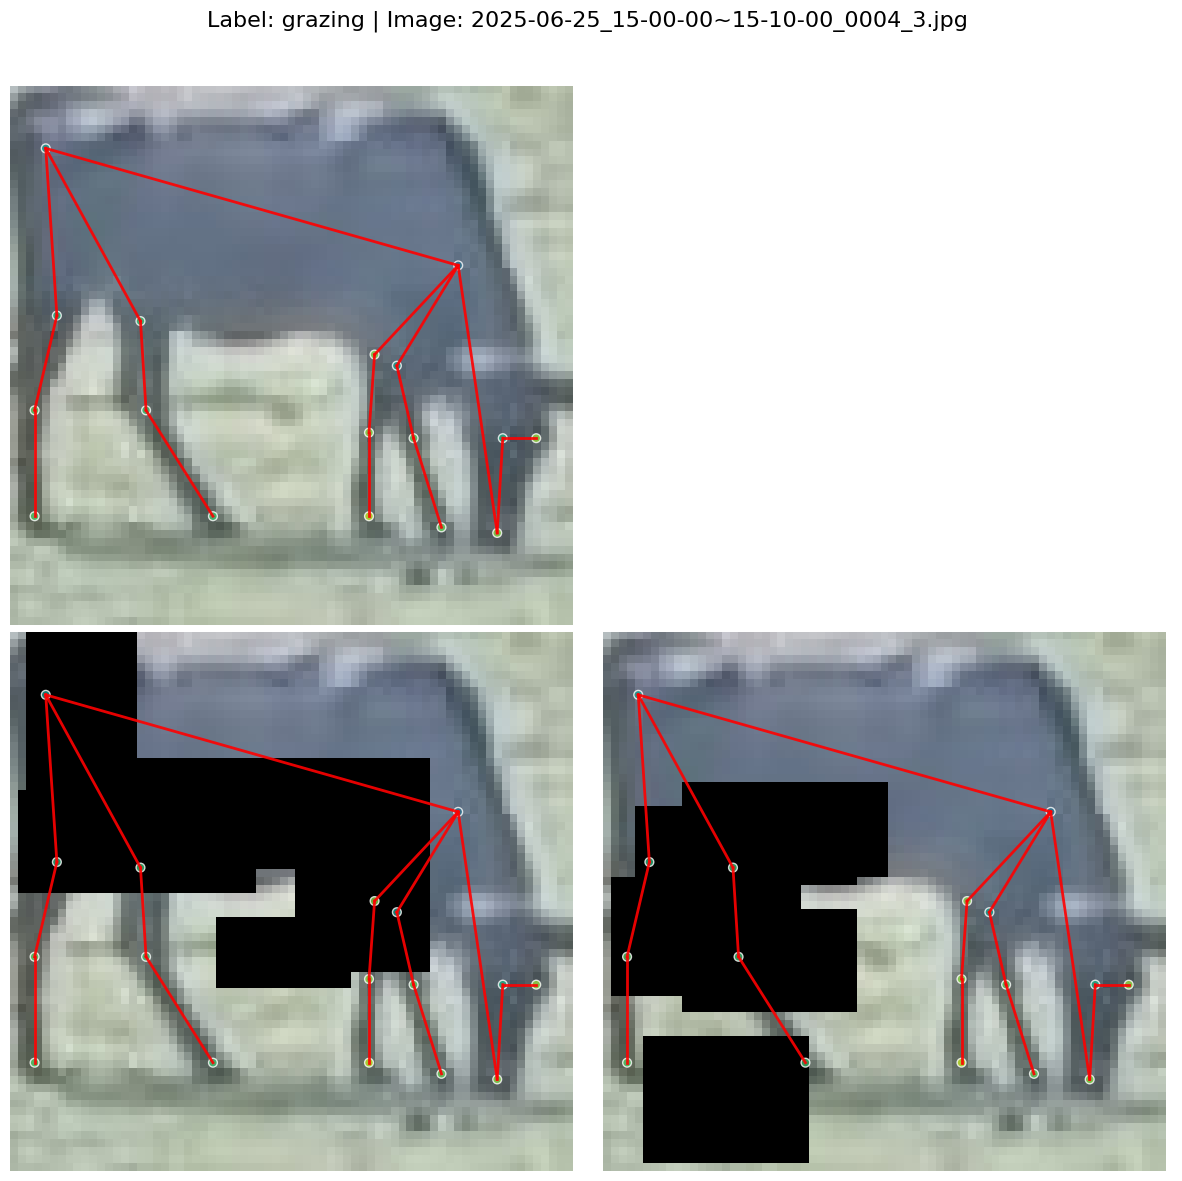

In [246]:
# 1. サンプルデータを取得
img_path = "2025-06-25_15-00-00~15-10-00_0004_3.jpg"
row = df.loc[df['image_path'].str.contains(img_path)].iloc[0]
image_path = row['image_path']
pose_path = row['pose_path']
original_image = Image.open(image_path).convert('RGB')
loaded_skeleton = np.load(pose_path)
label = label_map.get(row['Label'], 0)
label_tensor = torch.tensor(label)

# 2. 各データ拡張を適用
# 提案手法
image_with_protection = aug_image_masking(original_image, loaded_skeleton, label_tensor)
# ランダムな手法
image_without_protection = aug_standard_cutout(original_image, None, None)

# 3. 描画領域を2x2で作成
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle(f"Label: {row['Label']} | Image: {os.path.basename(image_path)}", fontsize=16)

# 骨格の座標と信頼度、接続情報を準備
x = loaded_skeleton[:, 0]
y = loaded_skeleton[:, 1]
confidence = loaded_skeleton[:, 2]
body_parts_connections = {
    'head': [0, 1, 2],
    'torso': [2, 3, 4],
    'left_front_leg': [3, 5, 6, 7],
    'right_front_leg': [3, 8, 9, 10],
    'left_hind_leg': [4, 11, 12, 13],
    'right_hind_leg': [4, 14, 15, 16]
}

# 骨格を描画するヘルパー関数を定義
def draw_skeleton(ax, x, y, confidence, connections):
    """指定されたaxに骨格を描画する"""
    # 骨格の接続を描画
    for part, indices in connections.items():
        valid_indices = [idx for idx in indices if idx < len(x)]
        for j in range(len(valid_indices) - 1):
            start_idx, end_idx = valid_indices[j], valid_indices[j+1]
            ax.plot(x[[start_idx, end_idx]], y[[start_idx, end_idx]], 'r-', lw=2, alpha=0.9)
    # キーポイントを描画
    ax.scatter(x, y, c=confidence, s=40, cmap='viridis', alpha=0.8, edgecolors='w', vmin=0, vmax=1)


# 4. 指定された位置に各画像をプロット
# (0, 0) : 左上 - オリジナル
ax_original = axes[0, 0]
ax_original.imshow(original_image)
# ax_original.set_title('Base Image and Skeleton', fontsize=14)
draw_skeleton(ax_original, x, y, confidence, body_parts_connections)
ax_original.axis('off')

# (0, 1) : 右上 - 空白
axes[0, 1].axis('off')

# (1, 0) : 左下 - ランダム
ax_random = axes[1, 0]
ax_random.imshow(image_without_protection)
# ax_random.set_title('Original Cutout', fontsize=14)
draw_skeleton(ax_random, x, y, confidence, body_parts_connections)
ax_random.axis('off')

# (1, 1) : 右下 - 提案手法
ax_proposed = axes[1, 1]
ax_proposed.imshow(image_with_protection)
# ax_proposed.set_title('Proposed (Semantic Protection)', fontsize=14)
draw_skeleton(ax_proposed, x, y, confidence, body_parts_connections)
ax_proposed.axis('off')


# 5. レイアウトを調整して表示
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleとの重なりを避ける
plt.show()

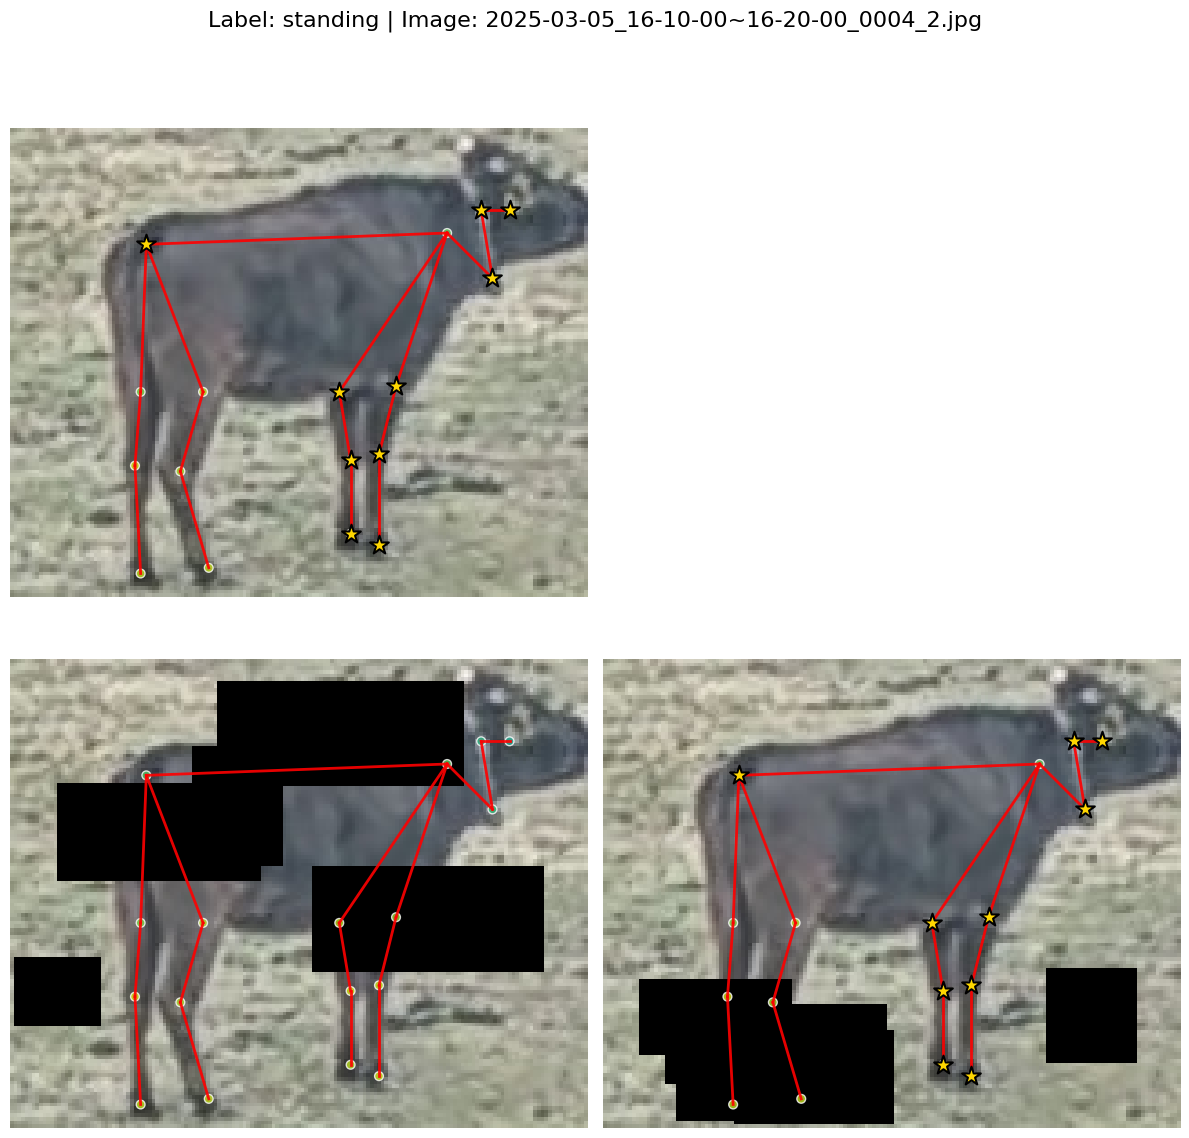

In [251]:
# 1. サンプルデータを取得
img_path = '2025-03-05_16-10-00~16-20-00_0004_2.jpg'
row = df.loc[df['image_path'].str.contains(img_path)].iloc[0]
image_path = row['image_path']
pose_path = row['pose_path']
original_image = Image.open(image_path).convert('RGB')
loaded_skeleton = np.load(pose_path)
label = label_map.get(row['Label'], 0)
label_tensor = torch.tensor(label)

# 2. 各データ拡張を適用
# 提案手法
image_with_protection = aug_image_masking(original_image, loaded_skeleton, label_tensor)
# ランダムな手法
image_without_protection = aug_standard_cutout(original_image, None, None)

# 3. 描画領域を2x2で作成
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle(f"Label: {row['Label']} | Image: {os.path.basename(image_path)}", fontsize=16)

# 骨格の座標と信頼度、接続情報を準備
x = loaded_skeleton[:, 0]
y = loaded_skeleton[:, 1]
confidence = loaded_skeleton[:, 2]
non_protected_parts = ['left_hind_leg', 'right_hind_leg']
body_parts_connections = {
    'head': [0, 1, 2],
    'torso': [2, 3, 4],
    'left_front_leg': [3, 5, 6, 7],
    'right_front_leg': [3, 8, 9, 10],
    'left_hind_leg': [4, 11, 12, 13],
    'right_hind_leg': [4, 14, 15, 16]
}
protected_parts = list(set(body_parts_connections.keys()) - set(non_protected_parts))
protected_parts_indices = {idx for part in protected_parts for idx in joint_map.get(part, [])}

# 骨格を描画するヘルパー関数を定義
def draw_skeleton(ax, x, y, confidence, connections, protected_parts_indices=None):
    """指定されたaxに骨格を描画する"""
    # 骨格の接続を描画
    for part, indices in connections.items():
        valid_indices = [idx for idx in indices if idx < len(x)]
        for j in range(len(valid_indices) - 1):
            start_idx, end_idx = valid_indices[j], valid_indices[j+1]
            ax.plot(x[[start_idx, end_idx]], y[[start_idx, end_idx]], 'r-', lw=2, alpha=0.9)
    # キーポイントを描画
    ax.scatter(x, y, c=confidence, s=40, cmap='viridis', alpha=0.8, edgecolors='w', vmin=0, vmax=1)
    # 保護対象のキーポイントを強調表示
    if protected_parts_indices:
        ax.scatter(
            x[list(protected_parts_indices)], y[list(protected_parts_indices)],
            marker='*',                # マーカーの形状を星印に設定
            s=200,                     # マーカーのサイズを大きくして目立たせる (例: 100 -> 200)
            c='gold',                  # マーカーの色を金色に固定して、他の点と明確に区別する
            edgecolors='black',        # 縁取りを黒色に設定し、視認性を高める
            linewidths=1.5,            # 縁取りの太さを設定する
            label='Protected Keypoints', # 凡例に表示するラベル
            zorder=3                   # 描画順を最前面に設定し、他の線や点に隠れないようにする
        )

# 4. 指定された位置に各画像をプロット
# (0, 0) : 左上 - オリジナル
ax_original = axes[0, 0]
ax_original.imshow(original_image)
# ax_original.set_title('Base Image and Skeleton', fontsize=14)
draw_skeleton(ax_original, x, y, confidence, body_parts_connections, protected_parts_indices)
ax_original.axis('off')

# (0, 1) : 右上 - 空白
axes[0, 1].axis('off')

# (1, 0) : 左下 - ランダム
ax_random = axes[1, 0]
ax_random.imshow(image_without_protection)
# ax_random.set_title('Original Cutout', fontsize=14)
draw_skeleton(ax_random, x, y, confidence, body_parts_connections, None)
ax_random.axis('off')

# (1, 1) : 右下 - 提案手法
ax_proposed = axes[1, 1]
ax_proposed.imshow(image_with_protection)
# ax_proposed.set_title('Proposed (Semantic Protection)', fontsize=14)
draw_skeleton(ax_proposed, x, y, confidence, body_parts_connections, protected_parts_indices)
ax_proposed.axis('off')


# 5. レイアウトを調整して表示
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleとの重なりを避ける
plt.show()

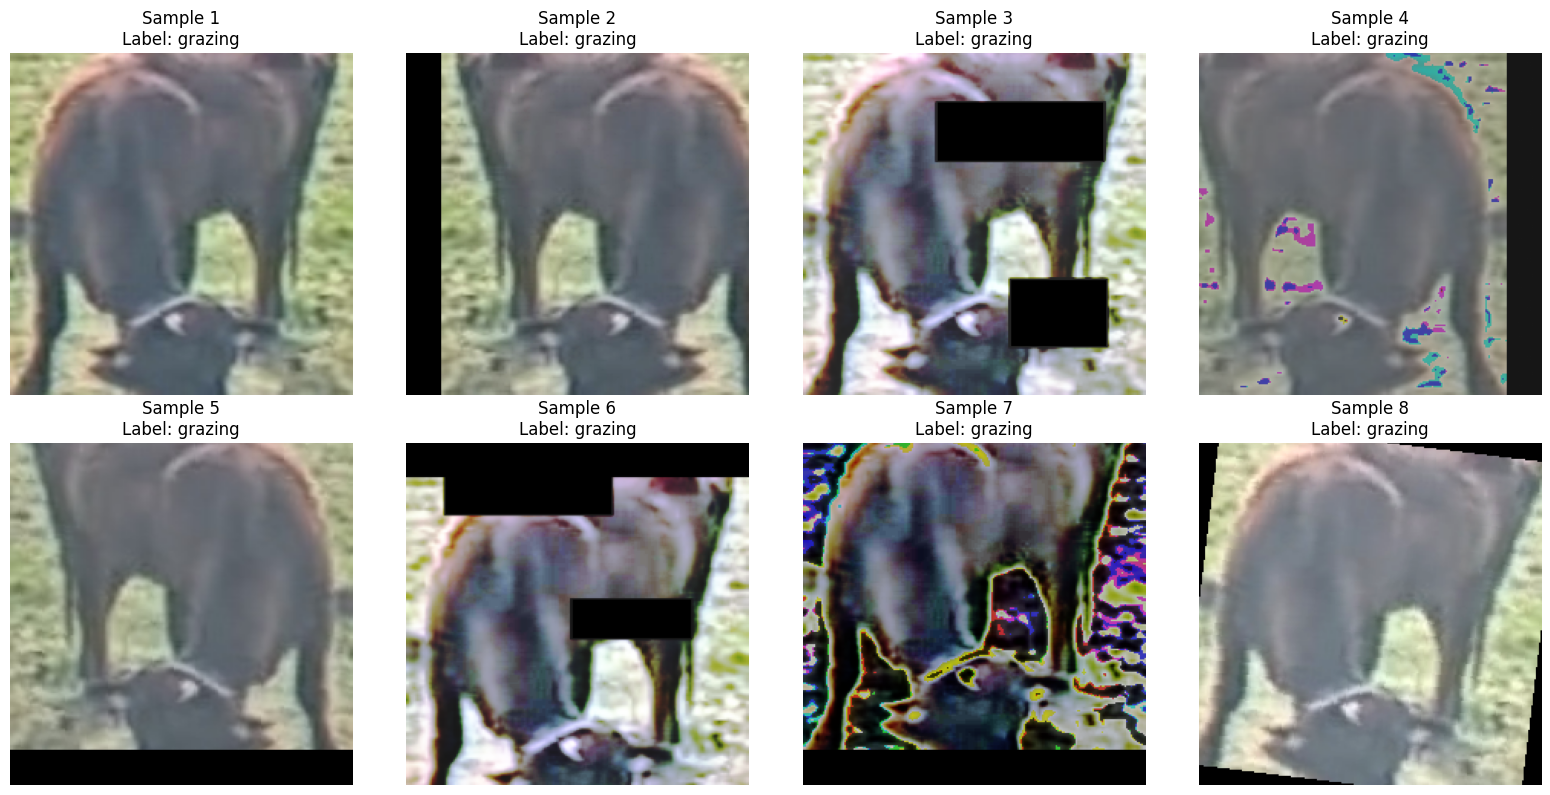

In [220]:
import os
import csv
import torch
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as T
import matplotlib.pyplot as plt
from train.action_with_image import CattleActionDataModule
from src.augmentation import ImageMaskingFromSkeleton

# DataModuleをインスタンス化する
with hydra.initialize(config_path="../train/conf", version_base=None):
    cfg = hydra.compose(config_name="action_train")
    data_module = CattleActionDataModule(data_cfg=cfg.data, aug_cfg=cfg.augmentation)

# setup()を実行してデータセットをロードする
data_module.setup('fit')
train_dataset = data_module.train_dataset

def denormalize(tensor, mean, std):
    """正規化されたテンソルを逆変換して表示可能な形式にする関数である。"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_augmentations(dataset, idx=0, num_samples=8):
    """
    単一の画像に対してデータ拡張を複数回適用し、その結果を可視化する関数である。
    
    Args:
        dataset (Dataset): 対象のデータセット。
        idx (int): 可視化するデータのインデックス。
        num_samples (int): 表示する拡張結果の数。
    """
    if len(dataset) <= idx:
        print(f"[ERROR] インデックス {idx} はデータセットの範囲外です。")
        return

    # 正規化のパラメータ
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]

    inv_map_label = {'grazing': 0, 'standing': 1, 'lying': 2, 'unknown': -1}
    map_label = {v: k for k, v in inv_map_label.items()}

    # 画像をグリッド表示する
    cols = 4
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i in range(num_samples):
        # データセットから毎回データを取得することで、ランダムな拡張が再適用される
        img_tensor, pose_tensor, label_tensor, _ = dataset[idx]

        # テンソルを可視化用に処理する
        img_denorm = denormalize(img_tensor.clone(), mean, std)
        img_np = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
        
        # 軸に画像を表示する
        ax = axes[i]
        ax.imshow(img_np)
        ax.set_title(f"Sample {i+1}\nLabel: {map_label[label_tensor.item()]}")
        ax.axis('off')

    # 不要なサブプロットを非表示にする
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 0番目のデータに対してデータ拡張を8回適用し、結果を可視化する
# このセルを再実行するたびに、異なる拡張結果が表示される
try:
    idx += 1
except NameError:
    idx = 0

idx %= len(train_dataset)
visualize_augmentations(train_dataset, idx=idx, num_samples=8)

# Interaction

In [221]:
# %%
import os
import random
import math
import numpy as np
import pandas as pd
import torch
import pickle
from PIL import Image, ImageDraw, UnidentifiedImageError
import matplotlib.pyplot as plt

In [ ]:
class ImageMaskingFromSkeletonForInteraction:
    """
    2頭の牛の骨格情報に基づき、元の画像にラベル不変のマスキングを適用するTransformである。
    """
    def __init__(self, joint_map, cutout_prob=0.5, n_holes=1,
                 scale=(0.02, 0.2), ratio=(0.3, 3.3), max_trials=10):
        self.joint_map = joint_map
        self.cutout_prob = cutout_prob
        self.n_holes = n_holes
        self.scale = scale
        self.ratio = ratio
        self.max_trials = max_trials

        # ラベル毎の「保護対象」部位を詳細化
        self.label_to_protected_parts = {
            0: [],                                      # no_interaction
            1: ['head', 'neck'],                        # interest
            2: ['head', 'neck', 'torso'],               # conflict
            3: ['head', 'neck', 'torso'], # mount
        }

    def __call__(self, image, skeleton1, skeleton2, label):
        if random.random() > self.cutout_prob:
            return image

        image_copy = image.copy()
        draw = ImageDraw.Draw(image_copy)
        img_w, img_h = image.size
        img_area = img_w * img_h

        label_item = label.item() if hasattr(label, 'item') else label
        protected_parts = self.label_to_protected_parts.get(label_item)
        if protected_parts is None:
            return image

        protected_indices = {idx for part in protected_parts for idx in self.joint_map.get(part, [])}
        
        all_protected_kpts = []
        for skeleton in [skeleton1, skeleton2]:
            skeleton_np = skeleton.cpu().numpy() if hasattr(skeleton, 'cpu') else np.array(skeleton)
            if skeleton_np.size == 0: continue
            
            valid_indices = [idx for idx in protected_indices if idx < len(skeleton_np)]
            if not valid_indices: continue

            kpts = skeleton_np[valid_indices, :2]
            valid_kpts = kpts[(kpts[:, 0] > 1) & (kpts[:, 1] > 1)]
            if valid_kpts.shape[0] > 0:
                all_protected_kpts.append(valid_kpts)

        if not all_protected_kpts:
            return image
            
        valid_protected_kpts = np.vstack(all_protected_kpts)

        for _ in range(self.n_holes):
            for _ in range(self.max_trials):
                hole_area = img_area * random.uniform(self.scale[0], self.scale[1])
                aspect_ratio = random.uniform(self.ratio[0], self.ratio[1])
                h = int(round(math.sqrt(hole_area / aspect_ratio)))
                w = int(round(math.sqrt(hole_area * aspect_ratio)))

                if h >= img_h or w >= img_w:
                    continue

                x1 = random.randint(0, img_w - w)
                y1 = random.randint(0, img_h - h)
                x2, y2 = x1 + w, y1 + h

                buf = 10
                is_colliding = np.any(
                    (valid_protected_kpts[:, 0] >= x1 - buf) &
                    (valid_protected_kpts[:, 0] < x2 + buf) &
                    (valid_protected_kpts[:, 1] >= y1 - buf) &
                    (valid_protected_kpts[:, 1] < y2 + buf)
                )

                if not is_colliding:
                    draw.rectangle([x1, y1, x2, y2], fill='black')
                    break
        return image_copy


class StandardCutout:
    """
    画像上のランダムな位置にCutoutを適用するTransform。
    骨格情報による保護は行わない。
    A transform that applies cutout to random locations on the image.
    Does not perform protection based on skeleton information.
    """
    def __init__(self, cutout_prob=0.5, n_holes=1,
                 scale=(0.02, 0.2), ratio=(0.3, 3.3)):
        self.cutout_prob = cutout_prob
        self.n_holes = n_holes
        self.scale = scale
        self.ratio = ratio

    def __call__(self, image):
        if random.random() > self.cutout_prob:
            return image

        image_copy = image.copy()
        draw = ImageDraw.Draw(image_copy)
        img_w, img_h = image.size
        img_area = img_w * img_h

        for _ in range(self.n_holes):
            hole_area = img_area * random.uniform(self.scale[0], self.scale[1])
            aspect_ratio = random.uniform(self.ratio[0], self.ratio[1])
            h = int(round(math.sqrt(hole_area / aspect_ratio)))
            w = int(round(math.sqrt(hole_area * aspect_ratio)))

            if h >= img_h or w >= img_w:
                continue

            x1 = random.randint(0, img_w - w)
            y1 = random.randint(0, img_h - h)
            x2, y2 = x1 + w, y1 + h
            draw.rectangle([x1, y1, x2, y2], fill='black')
        return image_copy

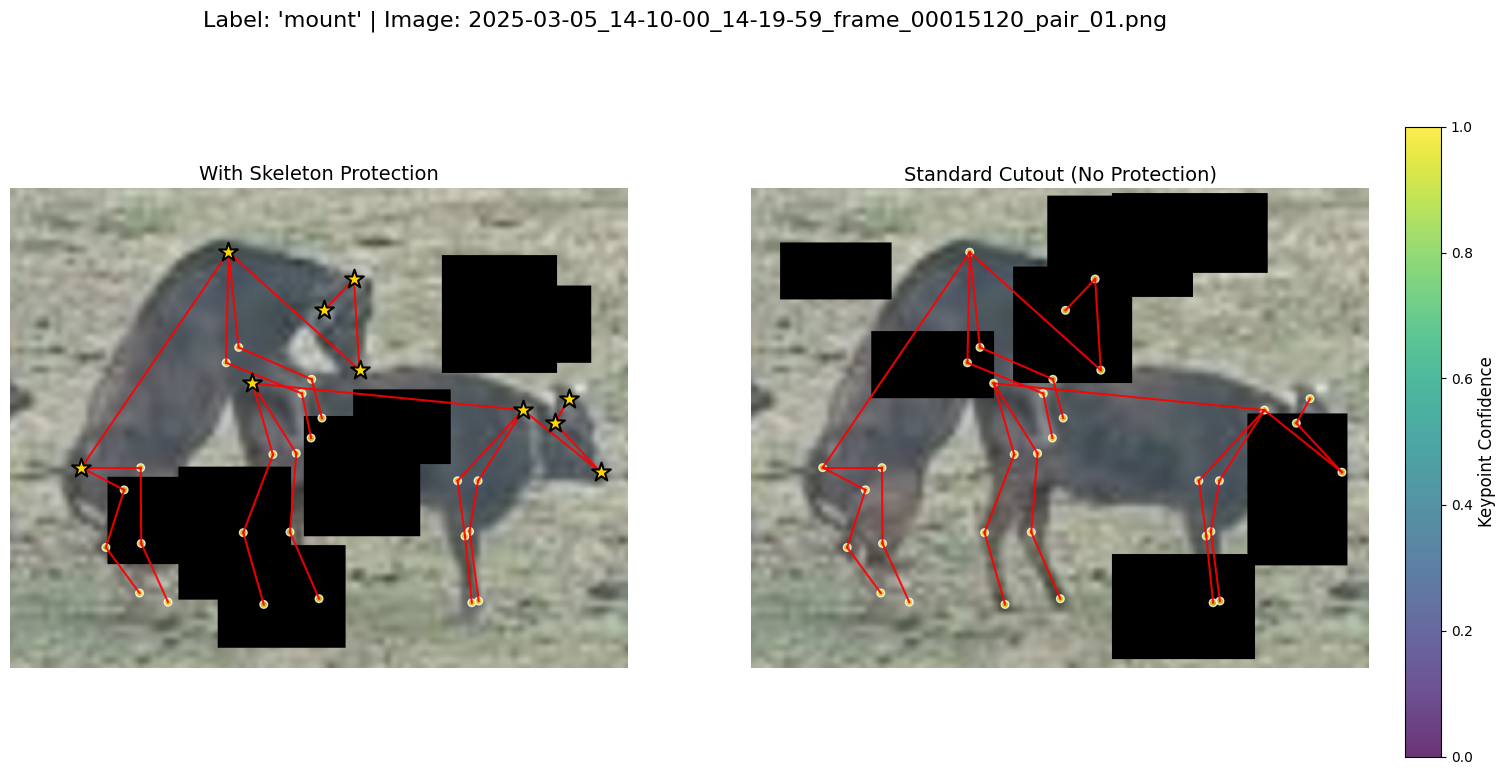

In [230]:
# --- 設定 (Configuration) ---
# データセットのルートディレクトリに合わせてパスを調整してください
# Please adjust the path to match the root directory of your dataset
DATA_ROOT = 'data/interaction' 
ANNOTATION_FILE = os.path.join(DATA_ROOT, 'master_v2.csv')
DELETE_BASE_DIRS = [
    '/mnt/nfs/processed/interaction_data/',
    'interaction_data/',
    'runs/extraction/'
]

protected_parts = ['head', 'neck', 'torso']
joint_map = {
    'head': [0, 1, 2], 'neck': [3], 'torso': [4], 'left_front_leg': [5, 6, 7],
    'right_front_leg': [8, 9, 10], 'left_hind_leg': [11, 12, 13], 'right_hind_leg': [14, 15, 16],
}
map_label = {
    'no_interaction': 0,
    'interest': 1,
    'conflict': 2,
    'mount': 3
}
protected_parts_indices = {idx for part in protected_parts for idx in joint_map.get(part, [])}
label_to_name = {v: k for k, v in map_label.items()}

# --- データ拡張のインスタンス化 (Instantiate augmentations) ---
aug_with_protection = ImageMaskingFromSkeletonForInteraction(
    joint_map=joint_map,
    cutout_prob=1.0, n_holes=7, scale=(0.02, 0.05), ratio=(0.5, 2.0),
)
aug_standard_cutout = StandardCutout(
    cutout_prob=1.0, n_holes=7, scale=(0.02, 0.05), ratio=(0.5, 2.0),
)


original_image = Image.open('/home/nakagawa/wrap_monitor_system/outputs/handle_skeltion/mounting.png').convert('RGB')
skeleton1 = np.load('/home/nakagawa/wrap_monitor_system/outputs/handle_skeltion/riding.npy', allow_pickle=True)
skeleton2 = np.load('/home/nakagawa/wrap_monitor_system/outputs/handle_skeltion/standing.npy', allow_pickle=True)
label_tensor = torch.tensor(3)  # mount

# 各データ拡張を適用
image_with_protection = aug_with_protection(original_image, skeleton1, skeleton2, label_tensor)
image_without_protection = aug_standard_cutout(original_image)

# --- 結果の描画 (Plotting the results) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
label_name = label_to_name.get(label, "unknown")
fig.suptitle(f"Label: '{label_name}' | Image: {os.path.basename(image_path)}", fontsize=16)

images_to_plot = [image_with_protection, image_without_protection]
titles = ['With Skeleton Protection', 'Standard Cutout (No Protection)']
skeletons_to_plot = [skeleton1, skeleton2]

# 体の部位ごとの接続
body_parts_connections = {
    'head': [0, 1, 2], 'neck': [2, 3], 'torso_line': [3, 4],
    'left_front_leg': [3, 5, 6, 7], 'right_front_leg': [3, 8, 9, 10],
    'left_hind_leg': [4, 11, 12, 13], 'right_hind_leg': [4, 14, 15, 16]
}

for ax, img, title in zip(axes, images_to_plot, titles):
    ax.imshow(img)
    ax.set_title(title, fontsize=14)
    ax.axis('off')

    # 2頭分の骨格を描画
    for skeleton_data in skeletons_to_plot:
        if skeleton_data.size == 0: continue
        x = skeleton_data[:, 0]
        y = skeleton_data[:, 1]
        confidence = skeleton_data[:, 2]

        # 骨格の接続を描画
        for part, indices in body_parts_connections.items():
            for j in range(len(indices) - 1):
                start_idx, end_idx = indices[j], indices[j+1]
                if start_idx < len(x) and end_idx < len(x):
                    ax.plot(x[[start_idx, end_idx]], y[[start_idx, end_idx]], 'r-', lw=1.5, alpha=0.9)
        
        # キーポイントを描画
        scatter = ax.scatter(x, y, c=confidence, s=30, cmap='viridis', alpha=0.8, edgecolors='w', vmin=0, vmax=1)

        # 保護されたキーポイントを星印で強調表示
        if title == 'With Skeleton Protection':
            protected_x = x[list(protected_parts_indices)]
            protected_y = y[list(protected_parts_indices)]
            protected_c = confidence[list(protected_parts_indices)]
            ax.scatter(
                protected_x, 
                protected_y,
                marker='*',                # マーカーの形状を星印に設定
                s=200,                     # マーカーのサイズを大きくして目立たせる (例: 100 -> 200)
                c='gold',                  # マーカーの色を金色に固定して、他の点と明確に区別する
                edgecolors='black',        # 縁取りを黒色に設定し、視認性を高める
                linewidths=1.5,            # 縁取りの太さを設定する
                label='Protected Keypoints', # 凡例に表示するラベル
                zorder=3                   # 描画順を最前面に設定し、他の線や点に隠れないようにする
            )

# カラーバーを追加
fig.subplots_adjust(right=0.88, top=0.92)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Keypoint Confidence', fontsize=12)

plt.show()

[WARN] Skipping invalid sample: data/interaction/images/2025-03-05_17-40-00_17-50-00_frame_00009900_pair_02.png. Reason: Failed to interpret file 'data/interaction/poses_individual/2025-03-05_17-40-00_17-50-00_frame_00009900_pair_02_pose_1.npy' as a pickle. Retrying.
[WARN] Skipping invalid sample: data/interaction/images/2025-03-05_17-50-00_17-59-59_frame_00000450_pair_01.png. Reason: Failed to interpret file 'data/interaction/poses_individual/2025-03-05_17-50-00_17-59-59_frame_00000450_pair_01_pose_1.npy' as a pickle. Retrying.
[WARN] Skipping invalid sample: data/interaction/images/2025-03-05_17-50-00_17-59-59_frame_00000450_pair_01.png. Reason: Failed to interpret file 'data/interaction/poses_individual/2025-03-05_17-50-00_17-59-59_frame_00000450_pair_01_pose_1.npy' as a pickle. Retrying.
[WARN] Skipping invalid sample: data/interaction/images/2025-03-05_17-40-00_17-50-00_frame_00009900_pair_02.png. Reason: Failed to interpret file 'data/interaction/poses_individual/2025-03-05_17-4

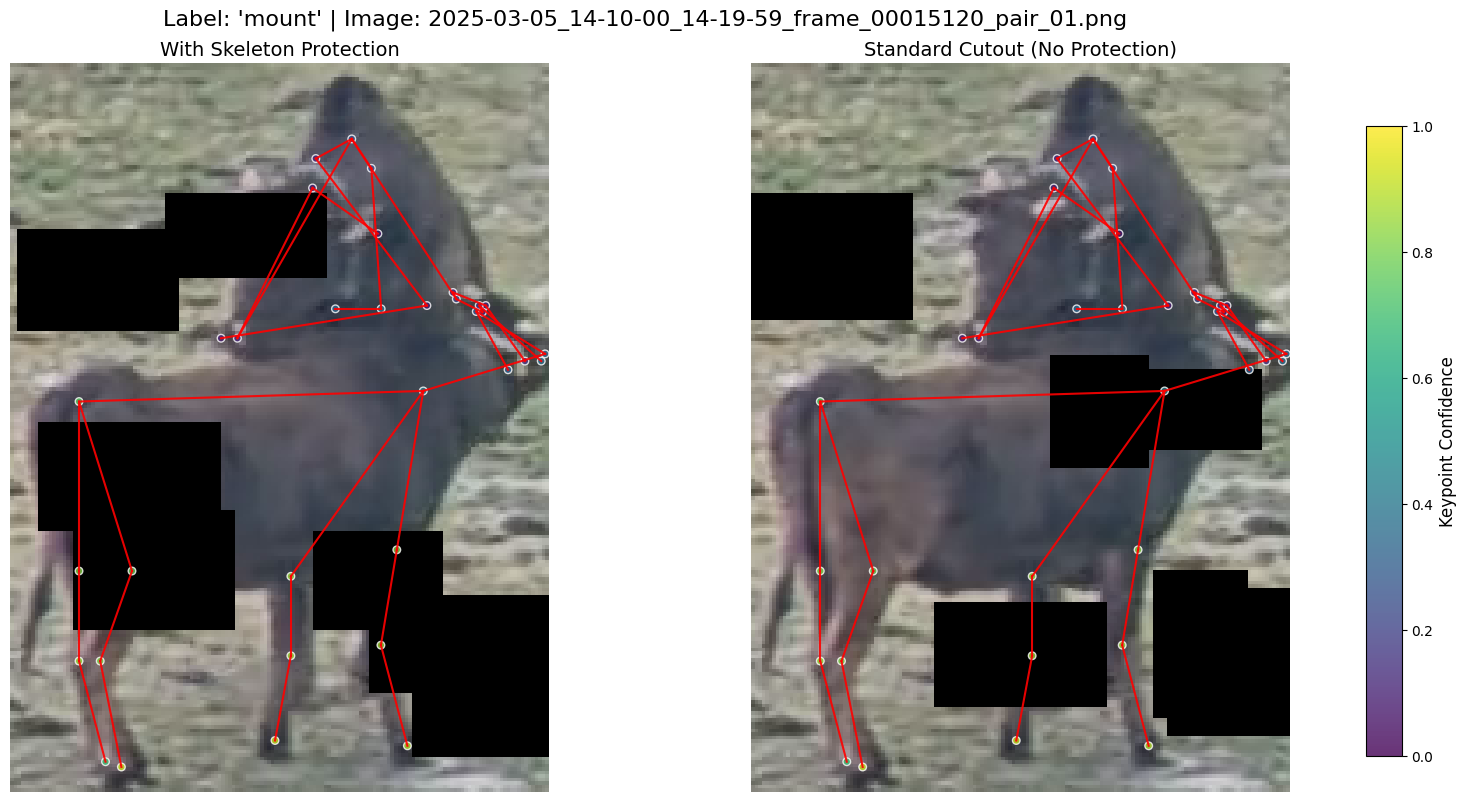

In [224]:
joint_map = {
    'head': [0, 1, 2], 'neck': [3], 'torso': [4], 'left_front_leg': [5, 6, 7],
    'right_front_leg': [8, 9, 10], 'left_hind_leg': [11, 12, 13], 'right_hind_leg': [14, 15, 16],
}
map_label = {
    'no_interaction': 0,
    'interest': 1,
    'conflict': 2,
    'mount': 3
}
label_to_name = {v: k for k, v in map_label.items()}

# --- データ拡張のインスタンス化 (Instantiate augmentations) ---
aug_with_protection = ImageMaskingFromSkeletonForInteraction(
    joint_map=joint_map,
    cutout_prob=1.0, n_holes=7, scale=(0.02, 0.05), ratio=(0.5, 2.0),
)
aug_standard_cutout = StandardCutout(
    cutout_prob=1.0, n_holes=7, scale=(0.02, 0.05), ratio=(0.5, 2.0),
)

# --- データ読み込みと前処理 (Data loading and preprocessing) ---
df = pd.read_csv(ANNOTATION_FILE)

# パスを整形
for delete_base_dir in DELETE_BASE_DIRS:
    df['image_path'] = df['image_path'].str.replace(delete_base_dir, '')
    df['pose_path_1'] = df['pose_path_1'].str.replace(delete_base_dir, '')
    df['pose_path_2'] = df['pose_path_2'].str.replace(delete_base_dir, '')

df['image_path'] = df['image_path'].apply(lambda x: os.path.join(DATA_ROOT, x))
df['pose_path_1'] = df['pose_path_1'].apply(lambda x: os.path.join(DATA_ROOT, x))
df['pose_path_2'] = df['pose_path_2'].apply(lambda x: os.path.join(DATA_ROOT, x))

# --- サンプルデータの取得と拡張の適用 (Get sample data and apply augmentations) ---
# 'interaction' ラベルを持つデータをサンプリング
while True:
    try:
        # 'interaction' ラベルを持つデータをサンプリング
        temp_df = df[df['label_v1'] == 'interaction'].dropna(subset='label_v2')
        sample_row = temp_df[temp_df['label_v2'] == 'mount'].sample(1).iloc[0]
        # sample_row = df[df['label_v1'] == 'interaction'].sample(1).iloc[0]

        image_path = sample_row['image_path']
        pose_path1 = sample_row['pose_path_1']
        pose_path2 = sample_row['pose_path_2']

        original_image = Image.open(image_path).convert('RGB')
        skeleton1 = np.load(pose_path1, allow_pickle=True)
        skeleton2 = np.load(pose_path2, allow_pickle=True)
        label = map_label.get(sample_row['label_v2'], None)
        # 読み込みに成功したらループを抜ける
        if label is not None:
            label_tensor = torch.tensor(label)
            break
    except (UnidentifiedImageError, OSError, FileNotFoundError, pickle.UnpicklingError, ValueError) as e:
        print(f"[WARN] Skipping invalid sample: {image_path}. Reason: {e}. Retrying.")
        continue

print('load sample data')
bbox_str = sample_row['merged_bbox_xyxy']
merged_bbox = [int(n) for n in bbox_str.strip('[]').split()]
crop_x_min, crop_y_min = merged_bbox[0], merged_bbox[1]

skeleton1[:, 0] -= crop_x_min
skeleton1[:, 1] -= crop_y_min
skeleton2[:, 0] -= crop_x_min
skeleton2[:, 1] -= crop_y_min

# 各データ拡張を適用
image_with_protection = aug_with_protection(original_image, skeleton1, skeleton2, label_tensor)
image_without_protection = aug_standard_cutout(original_image)

# --- 結果の描画 (Plotting the results) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
label_name = label_to_name.get(label, "unknown")
fig.suptitle(f"Label: '{label_name}' | Image: {os.path.basename(image_path)}", fontsize=16)

images_to_plot = [image_with_protection, image_without_protection]
titles = ['With Skeleton Protection', 'Standard Cutout (No Protection)']
skeletons_to_plot = [skeleton1, skeleton2]

# 体の部位ごとの接続
body_parts_connections = {
    'head': [0, 1, 2], 'neck': [2, 3], 'torso_line': [3, 4],
    'left_front_leg': [3, 5, 6, 7], 'right_front_leg': [3, 8, 9, 10],
    'left_hind_leg': [4, 11, 12, 13], 'right_hind_leg': [4, 14, 15, 16]
}

for ax, img, title in zip(axes, images_to_plot, titles):
    ax.imshow(img)
    ax.set_title(title, fontsize=14)
    ax.axis('off')

    # 2頭分の骨格を描画
    for skeleton_data in skeletons_to_plot:
        if skeleton_data.size == 0: continue
        x = skeleton_data[:, 0]
        y = skeleton_data[:, 1]
        confidence = skeleton_data[:, 2]

        # 骨格の接続を描画
        for part, indices in body_parts_connections.items():
            for j in range(len(indices) - 1):
                start_idx, end_idx = indices[j], indices[j+1]
                if start_idx < len(x) and end_idx < len(x):
                    ax.plot(x[[start_idx, end_idx]], y[[start_idx, end_idx]], 'r-', lw=1.5, alpha=0.9)
        
        # キーポイントを描画
        scatter = ax.scatter(x, y, c=confidence, s=30, cmap='viridis', alpha=0.8, edgecolors='w', vmin=0, vmax=1)

# カラーバーを追加
fig.subplots_adjust(right=0.88, top=0.92)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Keypoint Confidence', fontsize=12)

plt.show()

# Skelton

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import itertools

# 関節の部位情報をデータ拡張（マスキング）用に定義する。
joint_map = {
    'head': [0, 1, 2], 'neck': [3], 'torso': [4], 'left_front_leg': [5, 6, 7],
    'right_front_leg': [8, 9, 10], 'left_hind_leg': [11, 12, 13], 'right_hind_leg': [14, 15, 16],
}

def apply_rotation_shear(skeleton: np.ndarray, rotation_angle_deg: float, shear_x: float, shear_y: float) -> np.ndarray:
    """
    骨格データに対して回転およびせん断変換を適用する関数である。
    変換は骨格の中心点を基準に行われる。
    """
    center = np.mean(skeleton, axis=0)
    rotation_angle_rad = np.deg2rad(rotation_angle_deg)
    cos_val, sin_val = np.cos(rotation_angle_rad), np.sin(rotation_angle_rad)
    rotation_matrix = np.array([[cos_val, -sin_val], [sin_val, cos_val]])
    shear_matrix = np.array([[1, shear_x], [shear_y, 1]])
    transform_matrix = shear_matrix @ rotation_matrix
    transformed_skeleton = (skeleton - center) @ transform_matrix.T + center
    return transformed_skeleton

def apply_masking(skeleton: np.ndarray, joint_map: dict, num_parts_to_mask: int, num_joints_to_mask: int) -> np.ndarray:
    """
    骨格データに対して部位マスキングおよび結合マスキングを適用する関数である。
    マスクされた座標は (np.nan, np.nan) で置き換えられる。
    """
    augmented_skeleton = skeleton.copy()
    if num_parts_to_mask > 0:
        parts_to_mask = random.sample(list(joint_map.keys()), k=min(num_parts_to_mask, len(joint_map)))
        for part in parts_to_mask:
            for joint_index in joint_map[part]:
                augmented_skeleton[joint_index] = [np.nan, np.nan]
    if num_joints_to_mask > 0:
        available_indices = [i for i, joint in enumerate(augmented_skeleton) if not np.isnan(joint).any()]
        if available_indices:
            joints_to_mask = random.sample(available_indices, k=min(num_joints_to_mask, len(available_indices)))
            for joint_index in joints_to_mask:
                augmented_skeleton[joint_index] = [np.nan, np.nan]
    return augmented_skeleton

def add_noise(skeleton: np.ndarray, noise_stddev: float) -> np.ndarray:
    """
    骨格データの各関節座標に正規分布に従うノイズを付加する関数である。
    マスクされた関節（np.nan）にはノイズは付加されない。
    """
    valid_data_mask = ~np.isnan(skeleton)
    noise = np.random.normal(0, noise_stddev, skeleton.shape)
    noisy_skeleton = skeleton.copy()
    np.copyto(noisy_skeleton, skeleton + noise, where=valid_data_mask)
    return noisy_skeleton

def augment_skeleton(
    skeleton: np.ndarray, 
    joint_map: dict,
    augmentations_to_apply: list = None,
    rotation_range_deg: tuple = (-15.0, 15.0),
    shear_range: tuple = (-0.1, 0.1),
    max_parts_to_mask: int = 1,
    max_joints_to_mask: int = 2,
    noise_stddev: float = 0.5
) -> np.ndarray:
    """
    指定された骨格データに対して、リストで指定されたデータ拡張を適用する統合関数である。
    
    Args:
        skeleton (np.ndarray): 元の骨格データ。
        joint_map (dict): 関節と部位の対応辞書。
        augmentations_to_apply (list, optional): 適用する拡張手法のリスト。
            指定可能な項目: 'rotation_shear', 'masking', 'noise'。
            Noneの場合は全て適用する。
        ... (その他のパラメータ)
    """
    if augmentations_to_apply is None:
        augmentations_to_apply = ['rotation_shear', 'masking', 'noise']

    augmented_skeleton = skeleton.copy()

    # 1. 回転およびせん断
    if 'rotation_shear' in augmentations_to_apply:
        rotation_angle = random.uniform(*rotation_range_deg)
        shear_x, shear_y = random.uniform(*shear_range), random.uniform(*shear_range)
        augmented_skeleton = apply_rotation_shear(augmented_skeleton, rotation_angle, shear_x, shear_y)

    # 2. 部位/結合マスキング
    if 'masking' in augmentations_to_apply:
        num_parts = random.randint(0, max_parts_to_mask)
        num_joints = random.randint(0, max_joints_to_mask)
        augmented_skeleton = apply_masking(augmented_skeleton, joint_map, num_parts, num_joints)

    # 3. ノイズ付加
    if 'noise' in augmentations_to_apply and noise_stddev > 0:
        augmented_skeleton = add_noise(augmented_skeleton, noise_stddev)
        
    return augmented_skeleton


### 使用法 (Usage)

def visualize_skeleton(ax, skeleton_data, title, background_image=None):
    """
    指定されたmatplotlibのAxesオブジェクトに背景画像と骨格を描画する関数である。
    """
    ax.imshow(background_image)
    ax.set_title(title)
    ax.axis('off')
    valid_mask = ~np.isnan(skeleton_data[:, :2]).any(axis=1)
    if not np.any(valid_mask): return None
    coords = skeleton_data[valid_mask]
    x, y, confidence = coords[:, 0], coords[:, 1], coords[:, 2]
    body_parts_connections = {
        'head': [0, 1, 2], 'torso': [2, 3, 4], 'left_front_leg': [3, 5, 6, 7],
        'right_front_leg': [3, 8, 9, 10], 'left_hind_leg': [4, 11, 12, 13], 'right_hind_leg': [4, 14, 15, 16]
    }
    original_indices = np.where(valid_mask)[0]
    index_map = {orig_idx: new_idx for new_idx, orig_idx in enumerate(original_indices)}
    for part, indices in body_parts_connections.items():
        for j in range(len(indices) - 1):
            start_idx_orig, end_idx_orig = indices[j], indices[j + 1]
            if start_idx_orig in index_map and end_idx_orig in index_map:
                start_idx_new, end_idx_new = index_map[start_idx_orig], index_map[end_idx_orig]
                ax.plot(x[[start_idx_new, end_idx_new]], y[[start_idx_new, end_idx_new]], 'r-', lw=2, alpha=0.7)
    scatter = ax.scatter(x, y, c=confidence, s=40, cmap='viridis', alpha=0.8, edgecolors='w', vmin=0, vmax=1)
    return scatter

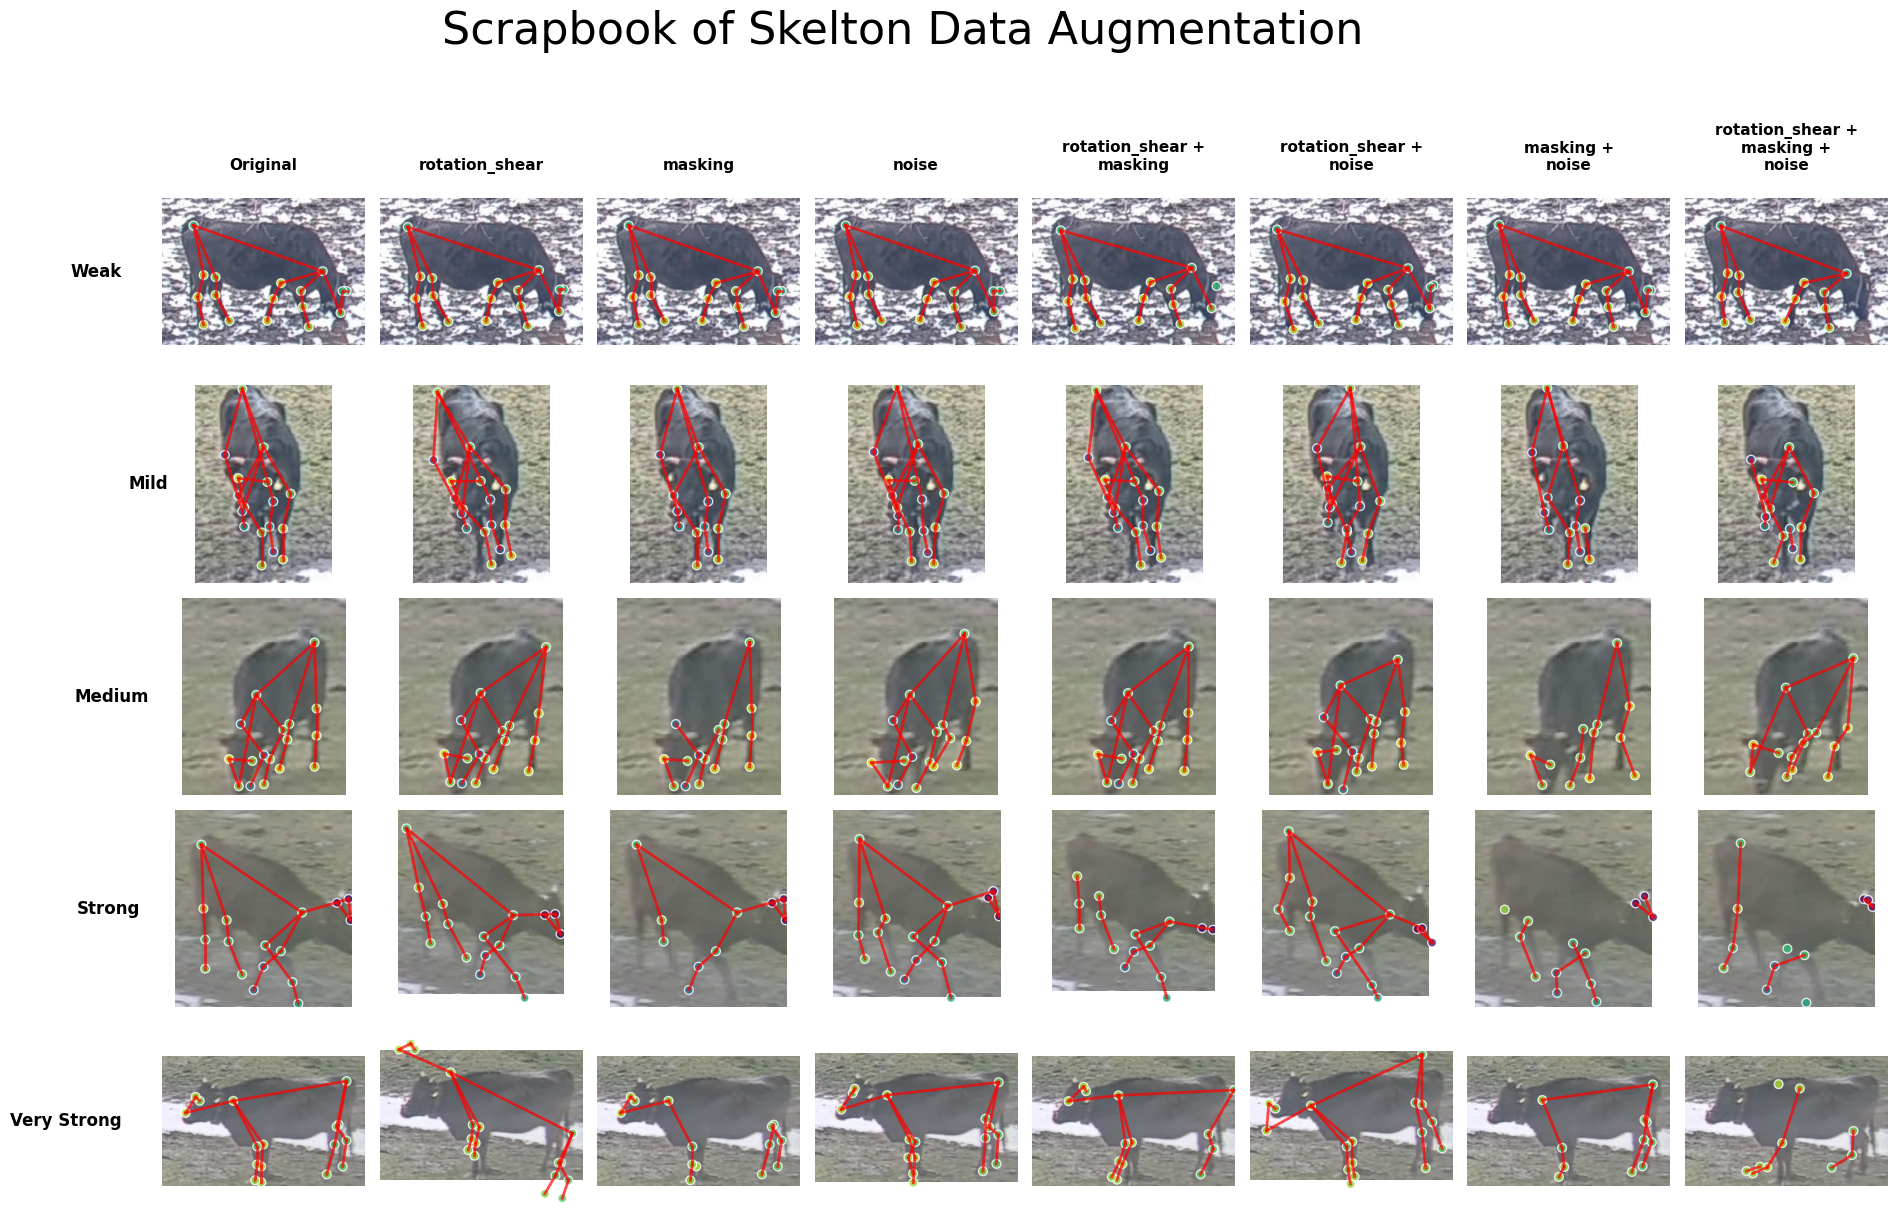

In [ ]:
# 0. データ拡張の強度プリセットを定義
strength_presets = [
    {'name': 'Weak', 'rot': 5, 'shear': 0.05, 'parts': 1, 'joints': 1, 'noise': 1.0},
    {'name': 'Mild', 'rot': 10, 'shear': 0.1, 'parts': 1, 'joints': 1, 'noise': 2.0},
    {'name': 'Medium', 'rot': 15, 'shear': 0.15, 'parts': 2, 'joints': 2, 'noise': 3.0},
    {'name': 'Strong', 'rot': 25, 'shear': 0.3, 'parts': 2, 'joints': 2, 'noise': 4.0},
    {'name': 'Very Strong', 'rot': 30, 'shear': 0.5, 'parts': 3, 'joints': 3, 'noise': 5.0}
]
num_strength_levels = len(strength_presets)

# 2. データ拡張の全組み合わせを生成
augmentation_types = ['rotation_shear', 'masking', 'noise']
all_combinations = [[]]
for i in range(1, len(augmentation_types) + 1):
    for combo in itertools.combinations(augmentation_types, i):
        all_combinations.append(list(combo))

# 3. 可視化の準備
num_combos = len(all_combinations)
fig, axes = plt.subplots(num_strength_levels, num_combos, figsize=(num_combos * 2.5, num_strength_levels * 2.5))

# 4. 各組み合わせと強度で拡張を実行し、可視化
for col_idx, combo in enumerate(all_combinations):
    for row_idx, preset in enumerate(strength_presets):
        ax = axes[row_idx, col_idx]

        # 対応する行のサンプルデータを読み込む
        row_data = df.iloc[row_idx]
        background_image = Image.open(row_data['image_path']).convert('RGB')
        original_skeleton = np.load(row_data['pose_path'])

        # 拡張を適用
        if not combo:
            augmented_skeleton = original_skeleton.copy()
        else:
            skeleton_coords_to_augment = original_skeleton[:, :2]
            augmented_coords = augment_skeleton(
                skeleton=skeleton_coords_to_augment,
                joint_map=joint_map,
                augmentations_to_apply=combo,
                rotation_range_deg=(-preset['rot'], preset['rot']),
                shear_range=(-preset['shear'], preset['shear']),
                max_parts_to_mask=preset['parts'],
                max_joints_to_mask=preset['joints'],
                noise_stddev=preset['noise']
            )
            augmented_skeleton = np.hstack([augmented_coords, original_skeleton[:, 2:3]])
        
        # 可視化関数を呼び出す
        visualize_skeleton(ax, augmented_skeleton, "", background_image)

        # --- ★ラベル表示の修正箇所★ ---
        # [修正点1] 列ラベル（組み合わせ）を一番上の行に設定
        if row_idx == 0:
            combo_name = "Original" if not combo else " +\n".join(combo)
            ax.set_title(combo_name, fontsize=11, weight='bold', pad=20)

        # [修正点2] 行ラベル（強度）を一番左の列にテキストとして描画
        if col_idx == 0:
            # Axes座標系を使い、プロットの左側にテキストを配置する
            ax.text(
                -0.2, 0.5, preset['name'],
                transform=ax.transAxes,
                fontsize=12, weight='bold', ha='right', va='center'
            )
    
fig.suptitle("Scrapbook of Skelton Data Augmentation", fontsize=32)
# [修正点3] ラベルが表示されるように左マージンを確保
plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.show()